# Sunspots
Sunspots are temporary phenomena on the sun's photosphere that appear as spots darker than the surrounding areas. They are caused by the sun's magnetic field and are associated with solar activity, including solar flares and other space weather events.

One of the most well-known datasets of sunspot numbers is the "Monthly Mean Total Sunspot Number," maintained by the World Data Center SILSO, Royal Observatory of Belgium. This dataset provides monthly averages of sunspot counts from 1749 to the present.

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

#### 1. Download the dataset from https://www.sidc.be/SILSO/INFO/snmtotcsv.php and import it to pandas.
You find a decription at https://www.sidc.be/SILSO/infosnmtot.

In [2]:
# Loading the Data
df = pd.read_csv('SN_m_tot_V2.0.csv', sep=';',header=None)
df.head()

,0,1,2,3,4,5,6
0,1749,1,1749.042,96.7,-1.0,-1,1
1,1749,2,1749.123,104.3,-1.0,-1,1
2,1749,3,1749.204,116.7,-1.0,-1,1
3,1749,4,1749.288,92.8,-1.0,-1,1
4,1749,5,1749.371,141.7,-1.0,-1,1


#### 2. Prepare the data.
* Convert year and month to a datetime.
* We need only the two variables `date` and `spot` and observations of the last 100 years.


In [3]:
# convert 'date' to datetime64
df['date'] = pd.to_datetime(df.loc[:,0].astype(str) + df.loc[:,1].astype(str), format='%Y%m')
df['spots'] = df.loc[:,3]
# keep only date and spots
df = df.loc[:,['date', 'spots']]
# observations of the last 100 years 
df1 = df[(df['date'] > '1924-04-01') & (df['date'] <= '2024-04-01')].copy()
df1

,date,spots
2104,1924-05-01,34.6
2105,1924-06-01,40.0
2106,1924-07-01,46.9
2107,1924-08-01,32.1
2108,1924-09-01,41.9
...,...,...
3299,2023-12-01,113.5
3300,2024-01-01,123.0
3301,2024-02-01,124.7
3302,2024-03-01,104.9


#### 3. Visualize the Data.
* Plot the time series data to visualize the trend and any cyclic patterns.

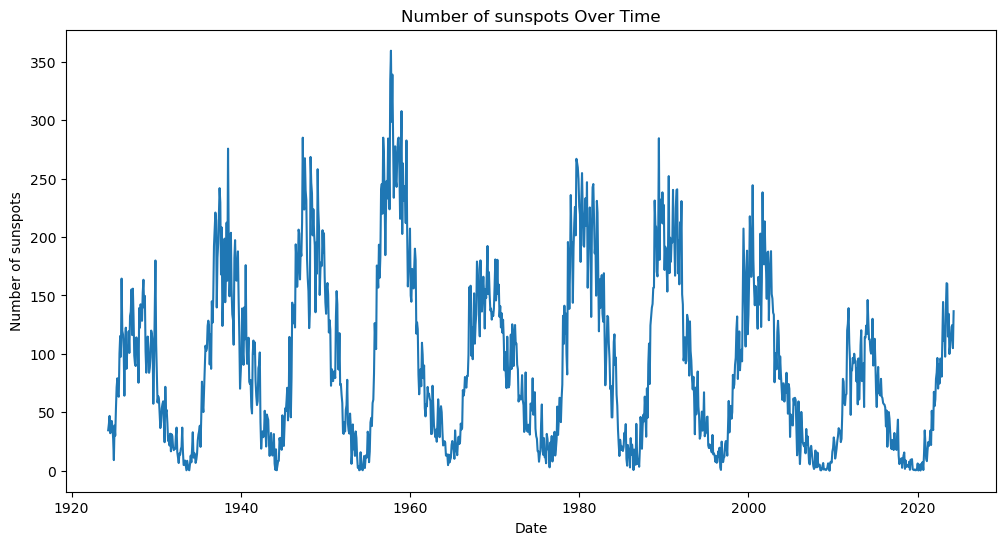

In [4]:
# Plotting with seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(data=df1, x='date', y='spots')
plt.title('Number of sunspots Over Time')
plt.xlabel('Date')
plt.ylabel('Number of sunspots')
plt.show()

#### 4. Decompose the Time Series into its components: trend, seasonality, and residuals.
Hint:  
The cycle length for sunspots, commonly known as the solar cycle or sunspot cycle, is approximately 11 years.  
This cycle represents the periodic change in the number of sunspots on the Sun's surface.

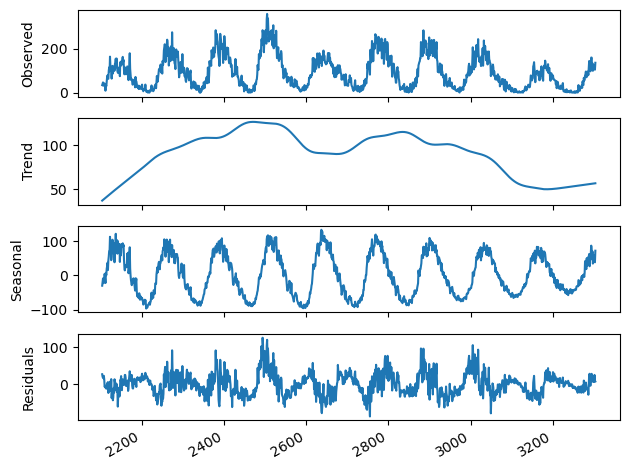

In [5]:
advanced_decomposition = STL(df1.spots, period=11*12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)

ax1.plot(advanced_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('Residuals')

fig.autofmt_xdate()
plt.tight_layout()


#### 5. Apply appropriate transformations to get a stationary time series.
* Visualize the resulting time series.
* Decompose the resulting time series.
* Test if the resulting time series is stationary.

In [6]:
df1['spots_diff_1'] = df1.spots.diff()
df1.head()

,date,spots,spots_diff_1
2104,1924-05-01,34.6,NaN
2105,1924-06-01,40.0,5.4
2106,1924-07-01,46.9,6.9
2107,1924-08-01,32.1,-14.8
2108,1924-09-01,41.9,9.8


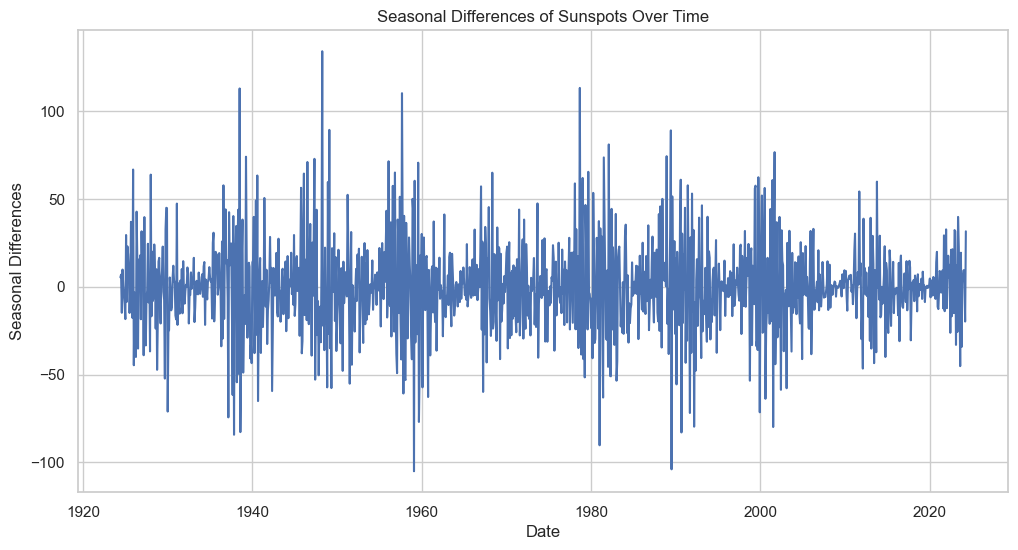

In [7]:
sns.set_theme(style='whitegrid')
plt.figure(figsize=(12, 6))
sns.lineplot(data=df1, x='date', y='spots_diff_1')
plt.title('Seasonal Differences of Sunspots Over Time')
plt.xlabel('Date')
plt.ylabel('Seasonal Differences')
plt.show()

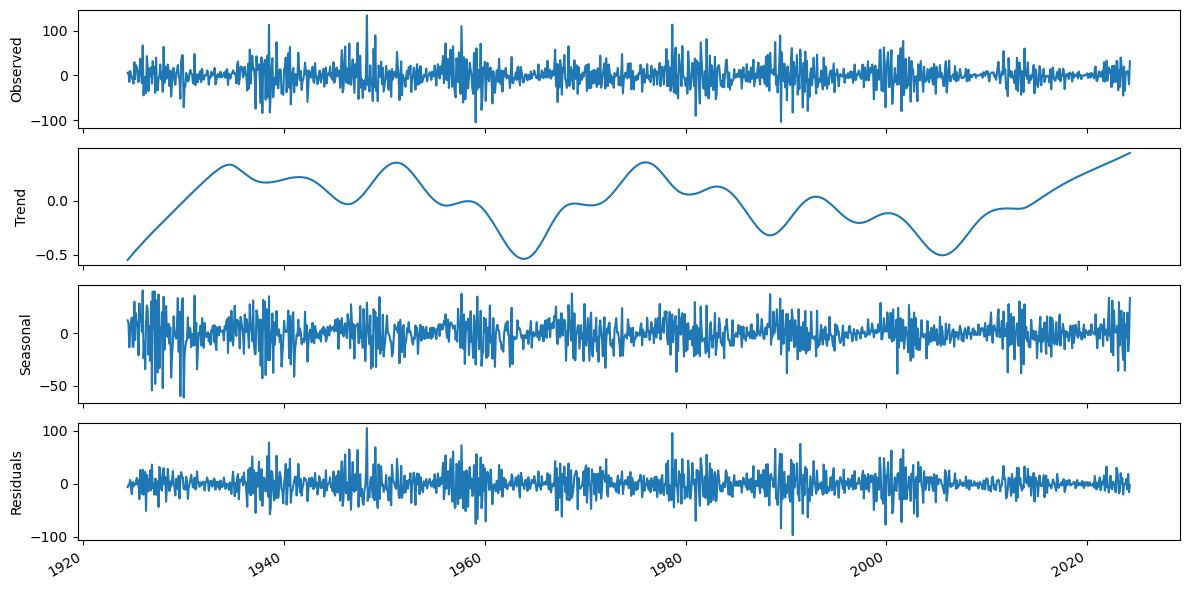

In [8]:
advanced_decomposition = STL(df1.set_index('date').spots_diff_1.dropna(), period=11*12).fit()
plt.rcdefaults()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(12, 6))

ax1.plot(advanced_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('Residuals')

fig.autofmt_xdate()

plt.tight_layout()
plt.show()

In [9]:
# ADF Test for stationarity
adf_test = adfuller(df1.set_index('date').spots_diff_1.dropna())
print(f'p-value: {adf_test[1]}')

p-value: 6.607339774813775e-06


p-value < 0.05: We reject the null hypothesis and conclude that the transformed time series is stationary.

#### 6. Compare the autocorrelation functions of the orgininal series with the transformed series.

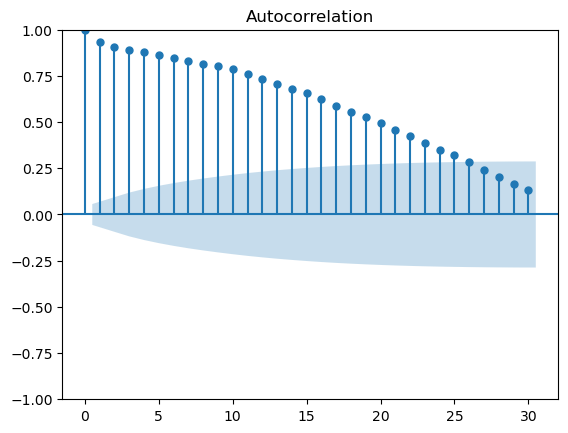

In [10]:
# ACF Plot of orgininal series
plot_acf(df1.set_index('date').spots, lags=30)
plt.show()

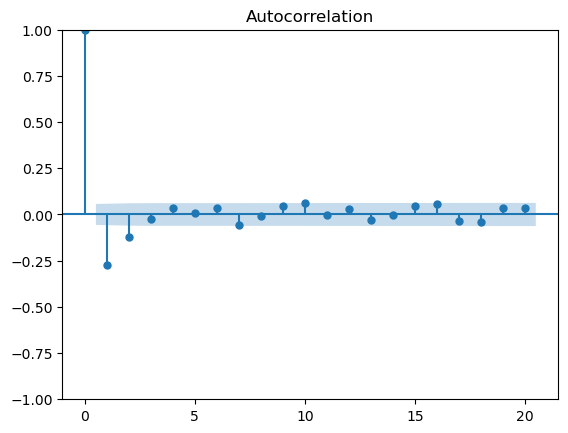

In [11]:
# ACF Plot of transformed series
plot_acf(df1.set_index('date').spots_diff_1.dropna(), lags=20)
plt.show()

Only the autocorrelations of the first 2 lags of the transformed series differ significantly from zero.  
This means that only the two previous values of the series (lags) may be helpful in predicting the current value.